## Тут просто ручная реализация логистической регрессии с сигмоидой и регуляризацией на датасете Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def prepare_dataset(df):
    df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
    df = df.fillna({'Age': df['Age'].mean()})
    df['Age'] /= 100
    df['Fare'] /= 100
    df['_bias'] = 1
    if 'Survived' in df.columns:
        return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
    else:
        return df

In [3]:
train_data = pd.read_csv('../data/titanic/train.csv')
train_features, train_answers = prepare_dataset(train_data)

In [4]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
X = train_features[features].to_numpy()
y = train_answers.to_numpy()

common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
X, y = X[X.shape[0] // 10:], y[X.shape[0] // 10:]
globX, globy = X.copy(), y.copy()

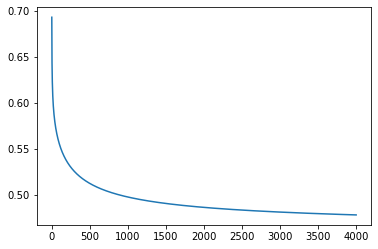

In [5]:
from tqdm.notebook import tqdm
iterations = 4000
alpha = 1e-1
tau = 1e-4

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

w = np.zeros((X.shape[1]))
errors = []
best_w = w
best_err = None
for it in tqdm(range(iterations)):
    errors.append(tau / 2 * np.sum(w**2) +
                  -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                 )
    if best_err is None or errors[-1] < best_err:
        best_w = w
        best_err = errors[-1]
    w -= alpha * np.power(it + 1, -0.5) * (-np.array([
        np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
        for j in range(X.shape[1])
    ]) / X.shape[0] + tau * w)

plt.plot([i for i in range(len(errors))], errors)

In [6]:
print(best_err)
pd.DataFrame({'feature': features, 'weight': best_w})

0.47854136193060065


,feature,weight
0,Pclass,-0.331237
1,Sex,-1.044771
2,Age,0.012158
3,SibSp,-0.116727
4,Parch,0.031288
5,Fare,0.425351
6,_bias,0.271490


In [7]:
train_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
print('Score: {}'.format( np.mean( train_predictions == common_test_y ) ))

Score: 0.797752808988764


In [8]:
topology_pair = [(0, 1)]
topology_cycle_3 = [(0, 1), (1, 2), (2, 0)] 
topology_grid_5 = [('center', 'west'), ('center', 'east'), ('center', 'north'), ('center', 'south'),
                   ('west', 'north'), ('north', 'east'), ('east', 'south'), ('west', 'south')]
'''
     @
    /|\
   @-@-@  topology_grid_5
    \|/
     @
'''
from utils.consensus_asyncio import *

Посчитаем среднее пяти чисел

In [9]:
consensus_shutdown = asyncio.Queue()
consensus_network = ConsensusNetwork(topology_grid_5, consensus_shutdown, debug=True)
agents = [ConsensusAgent(token, debug=True) for token in consensus_network.tokens]
for a in agents:
    consensus_network.register_agent(a)

async def shutdown_after_timeout(consensus_shutdown, timeout):
    await asyncio.sleep(timeout)
    await consensus_shutdown.put(SHUTDOWN)

tasks = [asyncio.create_task(a.run_round(np.random.uniform(), n + 1)) for n, a in enumerate(agents)]
asyncio.create_task(consensus_network.serve())
asyncio.create_task(shutdown_after_timeout(consensus_shutdown, 1))
for coro in asyncio.as_completed(tasks):
    t = await coro
    print(t)

0.6249032150931678
0.6249115721404616
0.6249051755031886
0.6248946038869359
0.6249009177087878


Master: Got 1/5 agents
Master: Got 2/5 agents
Master: Got 3/5 agents
Master: Got 4/5 agents
Master: Got 5/5 agents
Agent "west": heard from master
Agent "south": heard from master
Agent "center": heard from master
Agent "east": heard from master
Agent "north": heard from master
Agent "west": got neighbors from master
Agent "west": got consensus epsilon from master: 0.2375
Agent "south": got neighbors from master
Agent "south": got consensus epsilon from master: 0.2375
Agent "center": got neighbors from master
Agent "center": got consensus epsilon from master: 0.2375
Agent "east": got neighbors from master
Agent "east": got consensus epsilon from master: 0.2375
Agent "north": got neighbors from master
Agent "north": got consensus epsilon from master: 0.2375
Agent "west": running new round with v=0.07078055251819881, w=1
Agent "west": initialized. Waiting for NETWORK_READY
Agent "west": got NETWORK_READY
Agent "west": sending NEW_ROUND to master
Agent "south": running new round with v=0.

## Применение для титаника

In [10]:
def split_data(X, y, topology):
    tmpX = X.copy()
    tmpy = y.copy()
    tokens = list(set(np.array(topology).flatten()))
    num = len(tokens)
    result = dict()
    for i in range(num):
        left_tokens = num - i
        left_data = len(tmpX)
        ln = left_data // left_tokens
        result[tokens[i]] = (tmpX[:ln], tmpy[:ln])
        tmpX, tmpy = tmpX[ln:], tmpy[ln:]
    return result

In [11]:
from utils.consensus_asyncio import *
consensus_network = ConsensusNetwork(topology_grid_5, None)
consensus_network.describe()

Laplacian:
[[ 3 -1 -1  0 -1]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [ 0 -1 -1  3 -1]
 [-1  0 -1 -1  3]]
Eigenvalues: [0. 3. 3. 5. 5.]
Algebraic connectivity: 2.999999999999998
Perron matrix:
[[0.2875 0.2375 0.2375 0.     0.2375]
 [0.2375 0.2875 0.2375 0.2375 0.    ]
 [0.2375 0.2375 0.05   0.2375 0.2375]
 [0.     0.2375 0.2375 0.2875 0.2375]
 [0.2375 0.     0.2375 0.2375 0.2875]]
Eigenvalues: [-0.1875 -0.1875  0.2875  0.2875  1.    ]
Convergence speed: 0.18749999999999978


In [22]:
def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

progress_info = {}

async def learning_instance(X, y, agent, iterations=50000):
    alpha = 1e-1
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    train_err, test_err = [], []
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                     )
        test_err.append(-np.mean(np.log( sigmoid(common_test_y * (common_test_X @ w)) )))
        train_err.append(-np.mean(np.log( sigmoid(globy * (globX @ w)))))
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        w -= alpha * np.power(it + 1, -0.5) * grad
        w = await agent.run_round(w, X.shape[0])
        progress_info[agent.token] = (it + 1) / iterations

    return w, errors[-1], errors, test_err, train_err

async def run(topology, iterations=100, timeout=None, convergence_eps=1e-10, debug=False):
    global progress_info
    dl_data = split_data(X, y, topology)
    consensus_shutdown = asyncio.Queue()
    consensus_network = ConsensusNetwork(topology, consensus_shutdown, debug=debug)
    agents = [ConsensusAgent(token, convergence_eps=convergence_eps, debug=debug) for token in consensus_network.tokens]
    for a in agents:
        consensus_network.register_agent(a)
    
    progress_info = {}
    async def print_progress():
        from ipywidgets import IntProgress, FloatProgress, FloatText
        from IPython.display import display

        progress = FloatProgress(min=0.0, max=1.0, step=0.01, value=0.0)
        display(progress)
        while True:
            v = list(progress_info.values())
            if len(v) > 0:
                p = np.mean(v)
                progress.value = p
            await asyncio.sleep(0.25)

    if timeout:
        asyncio.create_task(shutdown_after_timeout(consensus_shutdown, timeout))
    progress_task = asyncio.create_task(print_progress())
    tasks = [asyncio.create_task(
                learning_instance(dl_data[a.token][0], dl_data[a.token][1], a, iterations=iterations)
             ) for a in agents]
    asyncio.create_task(consensus_network.serve())
    best_ws = []
    test_err = []
    train_err = []
    
    _, ((local_train_plt, global_train_plt), (test_plt, blank_)) = plt.subplots(2, 2, figsize=(18, 9))
    blank_.axis('off')
    local_train_plt.set_title('Local train error across agents')
    global_train_plt.set_title('Global train error across agents (full dataset)')
    test_plt.set_title('Test error across agents')
    for coro in asyncio.as_completed(tasks):
        best_w, best_err, errors, test_err, train_err = await coro
        best_ws.append(best_w)
        local_train_plt.plot([i for i in range(len(errors))], errors)
        global_train_plt.plot([i for i in range(len(train_err))], train_err)
        test_plt.plot([i for i in range(len(test_err))], test_err)
        
    progress_task.cancel()

    for w in best_ws:
        train_predictions = (sigmoid(common_test_X @ w) >= 0.5).astype(np.int) * 2 - 1
        print(f'Score: {np.mean( train_predictions == common_test_y )}')

    for w in best_ws:
        print(f'W: {w}')

FloatProgress(value=0.0, max=1.0)

Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]


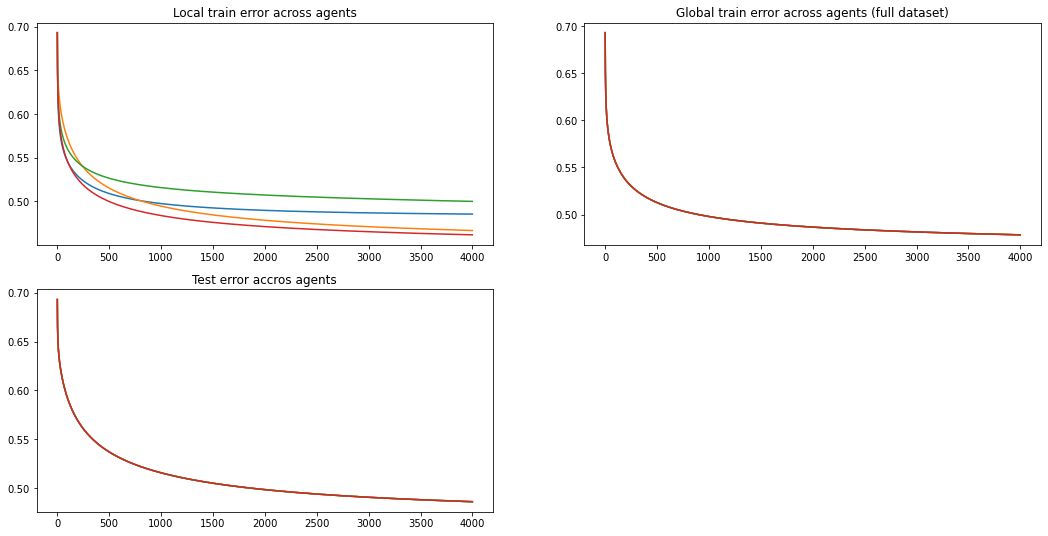

In [25]:
# K_4
await run([
    (0, 1), (0, 2), (0, 3),
            (1, 2), (1, 3),
                    (2, 3)
], 4000)

FloatProgress(value=0.0, max=1.0)

Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]


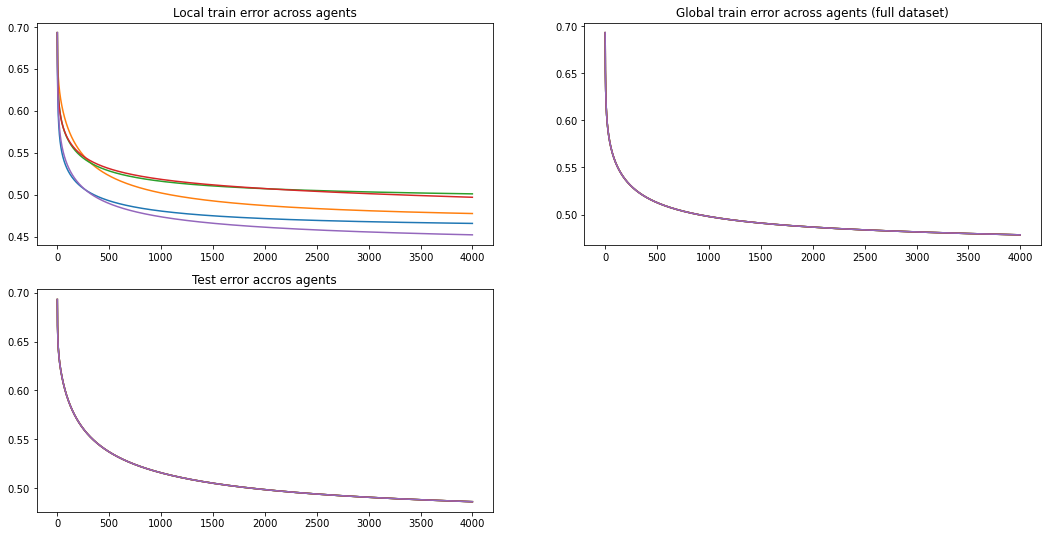

In [26]:
# grid 5
await run(topology_grid_5, 4000)

FloatProgress(value=0.0, max=1.0)

Score: 0.797752808988764
Score: 0.797752808988764
Score: 0.797752808988764
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]
W: [-0.33123728 -1.0447714   0.01215817 -0.11672705  0.03128755  0.42535079
  0.27149002]


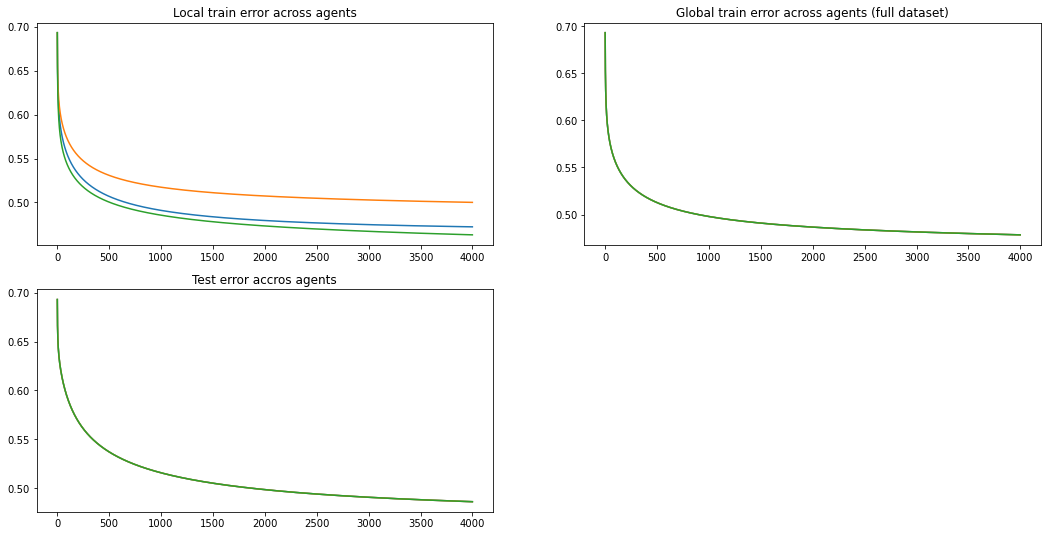

In [27]:
# 3-node cycle
await run(topology_cycle_3, 4000)

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.37763244 -1.15170579  0.01359448 -0.15597462 -0.02271425  0.54880775
  0.41782704]
W: [-0.37763244 -1.15170579  0.01359448 -0.15597462 -0.02271425  0.54880775
  0.41782704]
W: [-0.37763244 -1.15170579  0.01359448 -0.15597462 -0.02271425  0.54880775
  0.41782704]
W: [-0.37763244 -1.15170579  0.01359448 -0.15597462 -0.02271425  0.54880775
  0.41782704]
W: [-0.37763244 -1.15170579  0.01359448 -0.15597462 -0.02271425  0.54880775
  0.41782704]


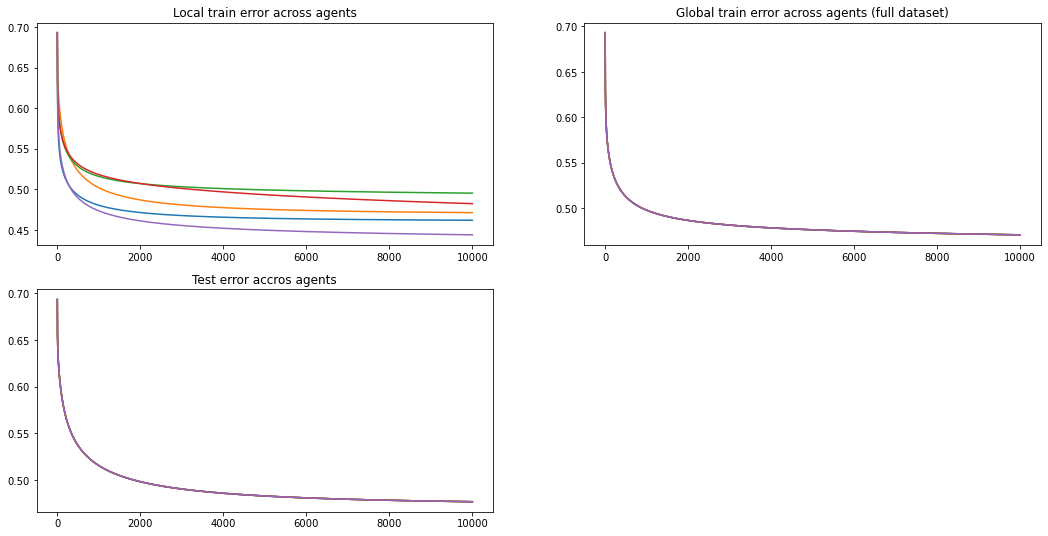

In [28]:
# grid 5, 10k iterations
await run(topology_grid_5, 10000)

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.38075189 -1.16430456  0.01426167 -0.15882518 -0.02463632  0.55793919
  0.42650609]
W: [-0.38072753 -1.16429674  0.01427259 -0.15879544 -0.02465476  0.55794996
  0.42652555]
W: [-0.38140969 -1.16633625  0.01429443 -0.15908897 -0.02469386  0.55893255
  0.42726828]
W: [-0.38168494 -1.16722003  0.0143131  -0.15919893 -0.02471747  0.55936807
  0.42761138]
W: [-0.38173119 -1.16722172  0.01430316 -0.15922998 -0.02471722  0.55935709
  0.4275883 ]


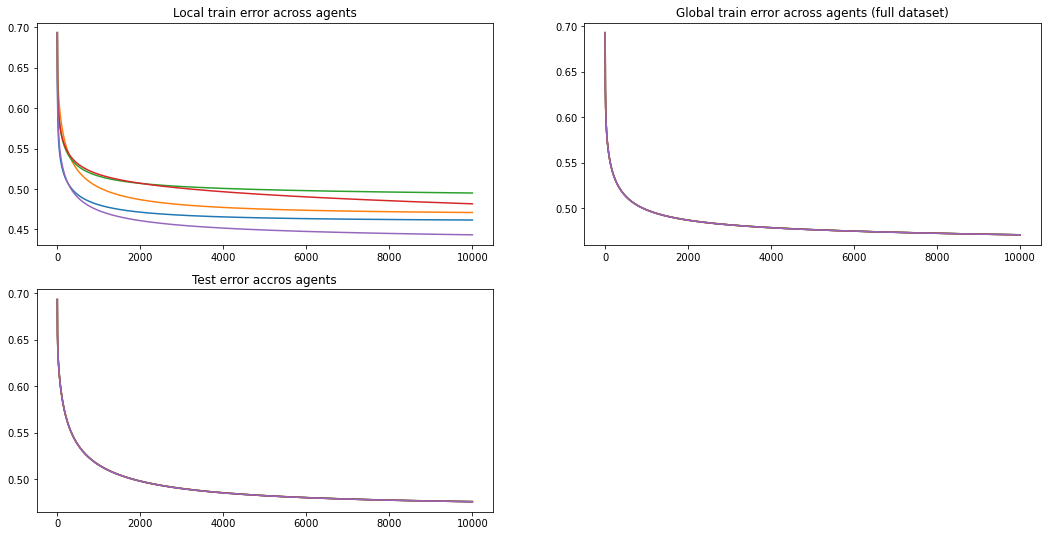

In [29]:
# grid 5, 10k iterations, low eps
await run(topology_grid_5, 10000, convergence_eps=1e-2)

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.38075168 -1.1643037   0.01426017 -0.15882451 -0.02463571  0.5579374
  0.42650566]
W: [-0.38072732 -1.16429588  0.0142711  -0.15879478 -0.02465415  0.55794817
  0.42652512]
W: [-0.38140949 -1.1663354   0.01429293 -0.1590883  -0.02469325  0.55893075
  0.42726785]
W: [-0.38168474 -1.16721917  0.01431161 -0.15919826 -0.02471686  0.55936627
  0.42761095]
W: [-0.38173098 -1.16722086  0.01430166 -0.15922932 -0.02471661  0.5593553
  0.42758787]


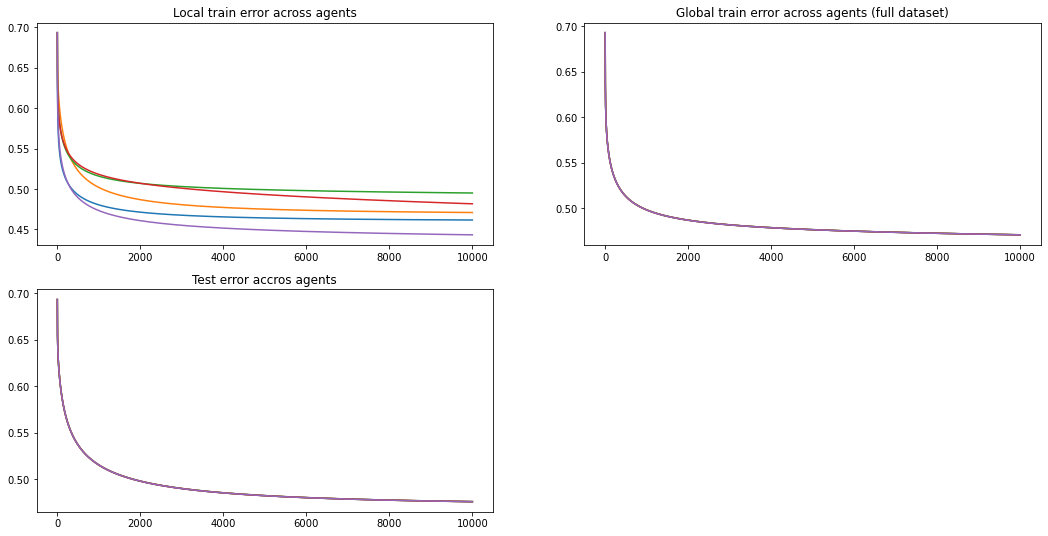

In [30]:
# grid 5, 10k iterations, low eps
await run(topology_grid_5, 10000, convergence_eps=1e-1)

FloatProgress(value=0.0, max=1.0)

Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
Score: 0.8089887640449438
W: [-0.38075168 -1.1643037   0.01426017 -0.15882451 -0.02463571  0.5579374
  0.42650566]
W: [-0.38072732 -1.16429588  0.0142711  -0.15879478 -0.02465415  0.55794817
  0.42652512]
W: [-0.38140949 -1.1663354   0.01429293 -0.1590883  -0.02469325  0.55893075
  0.42726785]
W: [-0.38168474 -1.16721917  0.01431161 -0.15919826 -0.02471686  0.55936627
  0.42761095]
W: [-0.38173098 -1.16722086  0.01430166 -0.15922932 -0.02471661  0.5593553
  0.42758787]


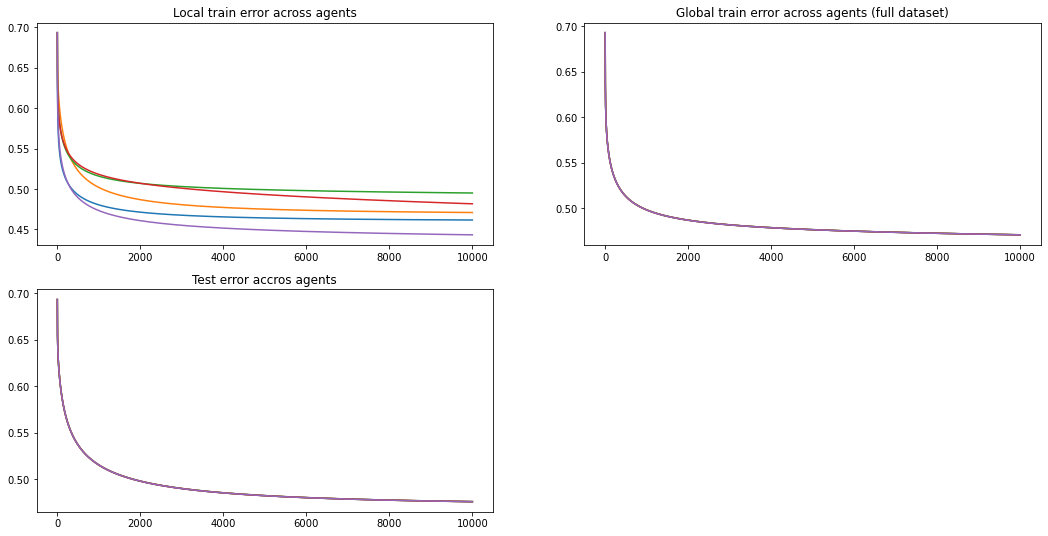

In [31]:
# grid 5, 10k iterations, too low eps => ~one iteration of consensus per step
await run(topology_grid_5, 10000, convergence_eps=10)

In [32]:
# Old learning algorithm
async def learning_instance(X, y, agent, iterations=50000):
    alpha = 5e-4
    tau = 1e-4

    w = np.zeros((X.shape[1]))
    errors = []
    train_err, test_err = [], []
    for it in range(iterations):
        errors.append(tau / 2 * np.sum(w**2) +
                      -np.mean(np.log( sigmoid(y * (X @ w)) ) )
                     )
        test_err.append(-np.mean(np.log( sigmoid(common_test_y * (common_test_X @ w)) )))
        train_err.append(-np.mean(np.log( sigmoid(globy * (globX @ w)))))
        grad = -np.array([
            np.dot(y * sigmoid(- y * (X @ w)), X[:, j])
            for j in range(X.shape[1])
        ]) / X.shape[0] + tau * w
        w -= alpha * grad
        w = await agent.run_round(w, X.shape[0])
        progress_info[agent.token] = (it + 1) / iterations
        if it % 2000 == 0: alpha *= 0.99

    return w, errors[-1], errors, test_err, train_err

FloatProgress(value=0.0, max=1.0)

Score: 0.7528089887640449
Score: 0.7528089887640449
Score: 0.7528089887640449
Score: 0.7528089887640449
Score: 0.7528089887640449
W: [-0.27570097 -0.70464363 -0.00433887 -0.04500785  0.06991059  0.22010923
  0.07762579]
W: [-0.27570053 -0.70464363 -0.00433877 -0.04500755  0.06991058  0.22010938
  0.07762604]
W: [-0.27570567 -0.70465595 -0.00433888 -0.04500849  0.06991179  0.22011321
  0.07762731]
W: [-0.27571255 -0.7046737  -0.00433893 -0.04500948  0.06991348  0.22011892
  0.0776294 ]
W: [-0.27571289 -0.70467373 -0.00433902 -0.04500978  0.06991356  0.22011878
  0.07762919]


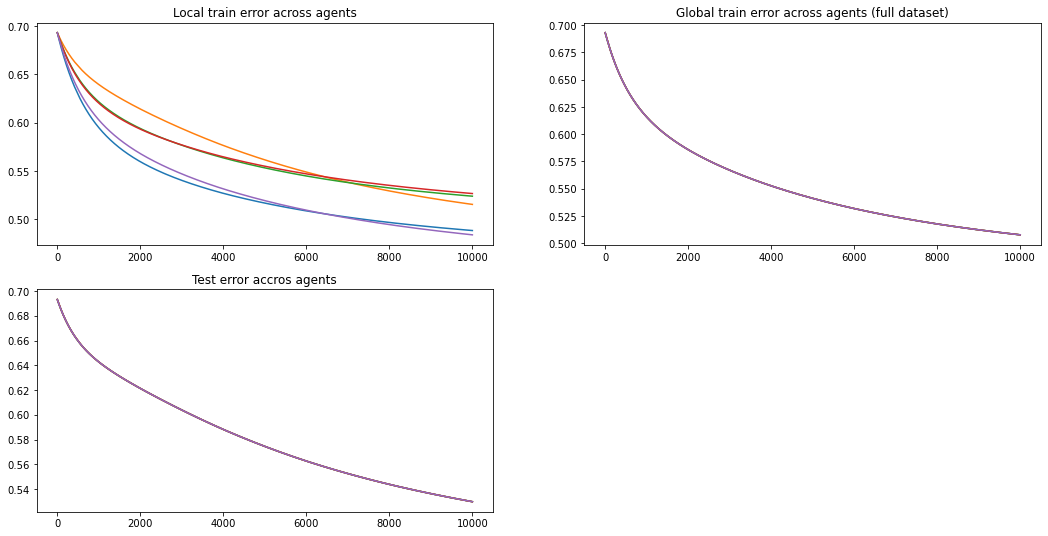

In [33]:
await run(topology_grid_5, 10000, convergence_eps=1e-4)